# AmadeusGPT Demo: MABe dataset

- please get an openAI user key: https://platform.openai.com/api-keys.
- We suggest to run the demos locally, but it can be viewed on Google Colab. Some interactive features might not be available.

In [ ]:
!pip install --pre amadeusgpt

- Let's test that your open AI API Key works:

In [ ]:
mykey = "paste-your-key-here"

In [3]:
from openai import OpenAI

client = OpenAI(api_key=mykey)

response = client.chat.completions.create(
    model="gpt-4",
    messages=[{"role": "user", "content": "Hello"}]
)
print(response.choices[0].message.content)

Hello! How can I assist you today?


In [4]:
import os
if 'OPENAI_API_KEY' not in os.environ:
     os.environ['OPENAI_API_KEY'] = mykey

In [5]:
from amadeusgpt import AMADEUS
from amadeusgpt.config import Config
import amadeusgpt
from amadeusgpt.utils import parse_result
from pathlib import Path
import matplotlib.pyplot as plt
from amadeusgpt import create_project

## Please upload the demo video and associated files:
- you can grab it from here: https://github.com/AdaptiveMotorControlLab/AmadeusGPT/tree/mwm/docs/examples/MABe

In [6]:
amadeus_root = Path(amadeusgpt.__file__).parent.parent

kwargs = {
    "keypoint_info.body_orientation_keypoints.neck" : "nose",
    "keypoint_info.body_orientation_keypoints.tail_base" : "tail base",
    "keypoint_info.body_orientation_keypoints.animal_center" : "neck",
    "keypoint_info.head_orientation_keypoints.nose" : "nose",
    "keypoint_info.head_orientation_keypoints.neck" : "neck",
    "video_info.scene_frame_number" : 1400,
}

config = create_project(data_folder = "../examples/MABe", # check the path to the data folder
                        result_folder = "results",
                        **kwargs
                        )

amadeus = AMADEUS(config, use_vlm=True)
video_file_paths = amadeus.get_video_file_paths()
print (video_file_paths)

Project created at results. Results will be saved to results
The project will load video files (*.mp4) and optionally keypoint files from ../examples/MABe
A copy of the project config file is saved at results/config.yaml
{'data_info': {'data_folder': '../examples/MABe',
               'result_folder': 'results',
               'video_suffix': '.mp4'},
 'keypoint_info': {'body_orientation_keypoints': {'animal_center': 'neck',
                                                  'neck': 'nose',
                                                  'tail_base': 'tail base'},
                   'head_orientation_keypoints': {'neck': 'neck',
                                                  'nose': 'nose'},
                   'include_confidence': False,
                   'use_3d': False},
 'llm_info': {'gpt_model': 'gpt-4o',
              'keep_last_n_messages': 2,
              'max_tokens': 4096,
              'temperature': 0.0},
 'object_info': {'load_objects_from_disk': False, 'use_grid_obj

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.003 $
current input tokens 438
current accumulated tokens 495
description of the image frame provided
```json
{
    "description": "The image shows a top view of three mice in a square enclosure with bedding.",
    "individuals": 3,
    "species": "topview_mouse",
    "background_objects": ["bedding", "enclosure"]
}
```
['../examples/MABe/EGS8X2MN4SSUGFWAV976.mp4']


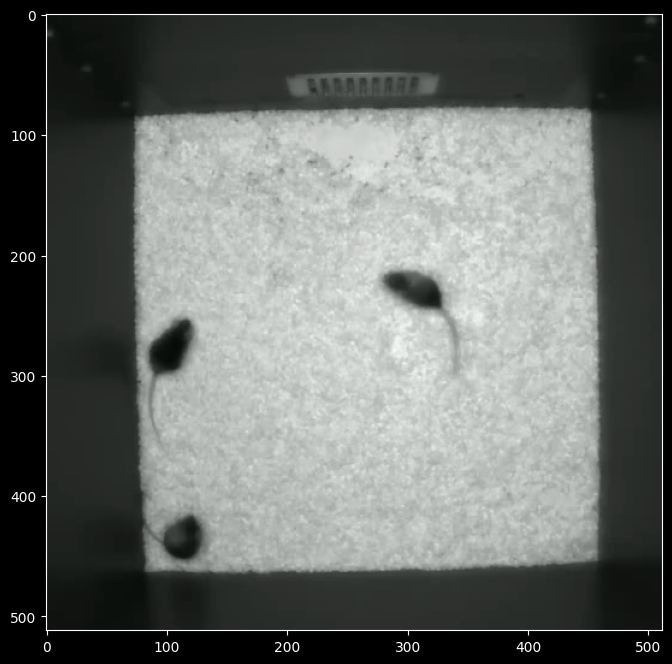

In [7]:
behavior_analysis = amadeus.get_behavior_analysis(video_file_path='../examples/MABe/EGS8X2MN4SSUGFWAV976.mp4', # check the path to the video file
                                                  keypoint_file_path='../examples/MABe/EGS8X2MN4SSUGFWAV976.h5') # check the path to the keypoint file
scene_image = behavior_analysis.visual_manager.get_scene_image()
plt.imshow(scene_image)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0224 $
current input tokens 2747
current accumulated tokens 3616


To accurately capture the "watching" behavior as defined, we need to use the `get_animals_animals_events` function from the `AnimalBehaviorAnalysis` class. This function allows us to specify conditions involving multiple animals, such as distance and relative head angle. 

The conditions for the "watching" behavior are:
- Distance between animals is less than 260 and larger than 50.
- Relative head angle between animals is less than 15 degrees.

We will use these conditions in the `cross_animal_query_list` parameter of the `get_animals_animals_events` function. Additionally, we will set the `smooth_window_size` to 15 as specified.

Here is the code to achieve this:

```python
def get_watching_events(identifier):
    '''
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint and config
    
    Returns:
    -------
    List[Event]: A list of events where the defined "watching" behavior occurs.
    '''
    # create_analysis returns an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Define the conditions for the "watching" behavior
    cross_animal_query_list = [
        'distance<260',
        'distance>50',
        'relative_head_angle<15'
    ]
    
    # Capture the watching events using the specified conditions
    watching_events = analysis.get_animals_animals_events(
        cross_animal_query_list=cross_animal_query_list,
        bodypart_names=None,
        otheranimal_bodypart_names=None,
        min_window=11,
        max_window=100000,
        smooth_window_size=15
    )
    
    return watching_events
```

This function will return a list of events where the "watching" behavior, as defined by the specified conditions, occurs.

videos generated to defaultdict(<class 'list'>, {<amadeusgpt.behavior_analysis.identifier.Identifier object at 0x31dd3a3c0>: ['results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_0.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_1.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_2.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_3.mp4']})
Open it with media player if it does not properly display in the notebook


[<amadeusgpt.analysis_objects.event.Event object at 0x31d891a00>, <amadeusgpt.analysis_objects.event.Event object at 0x31d890aa0>, <amadeusgpt.analysis_objects.event.Event object at 0x31d890110>, <amadeusgpt.analysis_objects.event.Event object at 0x31d890b60>]

[<amadeusgpt.analysis_objects.event.Event object at 0x31d891a00>, <amadeusgpt.analysis_objects.event.Event object at 0x31d890aa0>, <amadeusgpt.analysis_objects.event.Event object at 0x31d890110>, <amadeusgpt.analysis_objects.event.Event object at 0x31d890b60>]

[<amadeusgpt.analysis_objects.event.Event object at 0x31d891a00>, <amadeusgpt.analysis_objects.event.Event object at 0x31d890aa0>, <amadeusgpt.analysis_objects.event.Event object at 0x31d890110>, <amadeusgpt.analysis_objects.event.Event object at 0x31d890b60>]

[<amadeusgpt.analysis_objects.event.Event object at 0x31d891a00>, <amadeusgpt.analysis_objects.event.Event object at 0x31d890aa0>, <amadeusgpt.analysis_objects.event.Event object at 0x31d890110>, <amadeusgpt.analysis_objects.event.Event object at 0x31d890b60>]

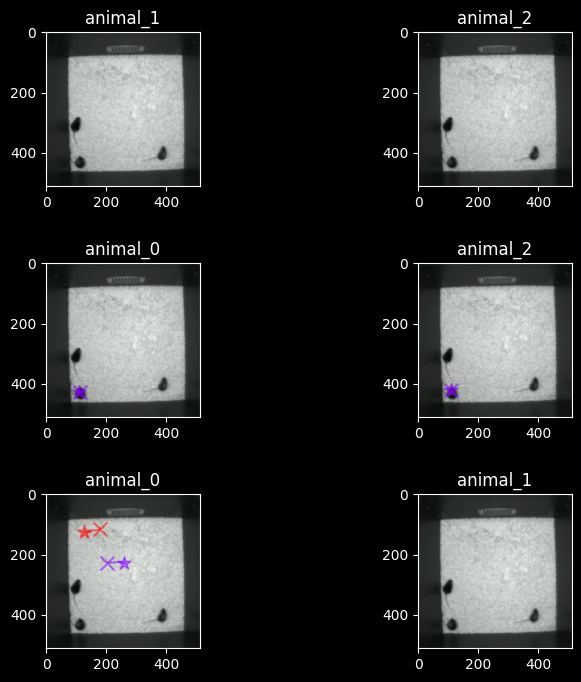

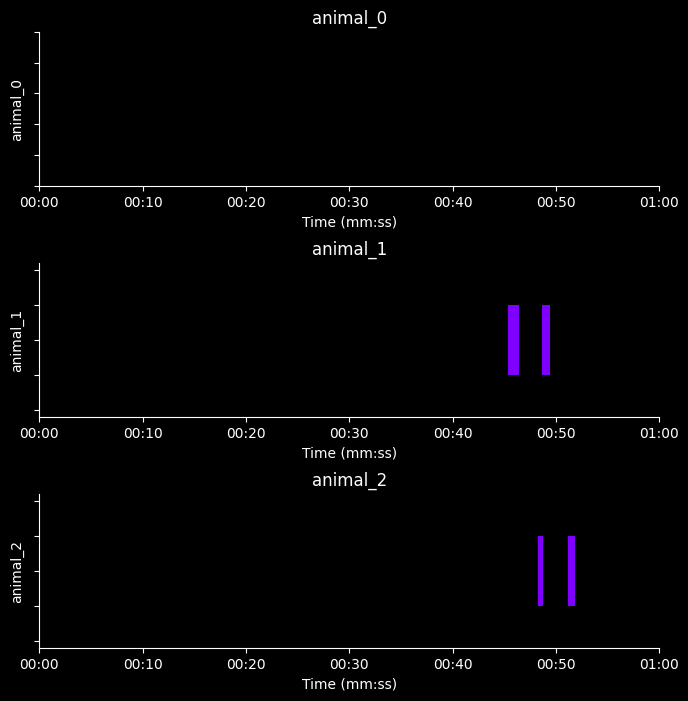

In [8]:
query = "Define watch as a social behavior where distance between animals is less than 260  \
and larger than 50 and head angle between animals is less than 15. The smooth_window_size is 15. Get watching"
qa_message = amadeus.step(query)
qa_message = parse_result(amadeus, qa_message)

### You can get a list of binary masks (equivalent to ethogram) for the underlying behavior, if your query is about retriving a described behavior

In [10]:
# the return masks is of shape (num_of_events, video_length)
# where each boolean array of (video_length,) is binary where True indicates whether the behavior is happening at that frame
masks = qa_message.get_masks()
print (masks)

{<amadeusgpt.behavior_analysis.identifier.Identifier object at 0x31d93c8f0>: array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
